## Initial imports

In [1]:
import carla
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from agents.navigation.global_route_planner_dao import GlobalRoutePlannerDAO
from agents.navigation.global_route_planner import GlobalRoutePlanner
from algs import splinepath
from agents.navigation.local_planner import RoadOption

## Carla setup

In [2]:
HOST = 'localhost'
PORT = 2000
client = carla.Client(HOST, PORT)
client.set_timeout(2.0)

In [3]:
client.load_world('Town03')  # Town01-Town07 are available

RuntimeError: failed to connect to newly created map

In [4]:
world = client.get_world()
bpl = world.get_blueprint_library()
sp = world.get_spectator()  # Get pointer to the spectator, i.e., camera in the server window

RuntimeError: trying to access an expired episode; a new episode was started in the simulation but an object tried accessing the old one.

In [ ]:
weather = world.get_weather()
world.set_weather(weather.ClearNoon)

## Initialize world

In [ ]:
p1 = carla.Location(x=200, y=-6, z=1)  # Start point
p2 = carla.Location(x=142.1, y=64, z=1)  # End point

In [5]:
rg = np.random.default_rng()
bp = rg.choice(bpl.filter('vehicle.audi.*'))

In [ ]:
actors = []
car = world.spawn_actor(bp, carla.Transform(p1))
actors.append(car)

## Plan route

In [6]:
RADIUS = 5
map = world.get_map()
dao = GlobalRoutePlannerDAO(map, sampling_resolution=RADIUS)
rp = GlobalRoutePlanner(dao)
rp.setup()
route = rp.trace_route(p1, p2)

## Create path object using nodes
p = np.array([(ri[0].transform.location.x, ri[0].transform.location.y)
              for ri in route])
path = splinepath.SplinePath(p, min_grid=3)

In [ ]:
t = route[0][0].transform
car.set_transform(t)
t.location.z += 15  # 15 meters above car
sp.set_transform(t)

## Add an obstacle on the route

In [7]:
car_obs = world.spawn_actor(bp, carla.Transform(route[5][0].transform.location))
actors.append(car_obs)

RuntimeError: Spawn failed because of collision at spawn position

## Move car to beginning of route

In [45]:
t = route[0][0].transform
car.set_transform(t)
t.location.z += 15  # 15 meters above car
sp.set_transform(t)

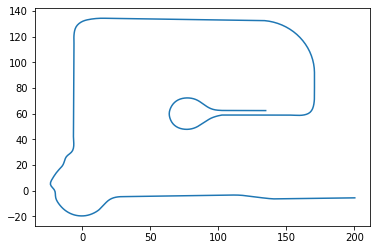

In [48]:
s = np.linspace(0, path.length, 500)
plt.figure(10, clear=True)
_ = plt.plot(path.x(s), path.y(s))

## State feedback controller

In [4]:
class StateFeedbackController:
    def __init__(self, K, L, path=None, goal_tol=1):
        self.plan = path
        self.K = K
        self.goal_tol = goal_tol
        self.d = []
        self.delta = []
        self.theta_e = []
        self.s_p = []
        self.L = L
        self.s0 = 0

        self.t = []
        self.w = []

    def heading_error(self, heading, s):
        """Compute theta error"""
        heading0, nc = self.plan.heading(s)
        cos_alpha = heading.dot(heading0)
        sin_alpha = np.float(np.cross(heading0, heading))

        theta_e = np.arctan2(sin_alpha, cos_alpha)
        return theta_e

    def u(self, t, w):
        def glob_stab_fact(x):
            """Series expansion of sin(x)/x around x=0."""
            return 1 - x**2/6 + x**4/120 - x**6/5040

        a = 0
        x, y, theta, v = w
        self.w.append(w)
        p_car = w[0:2]
        si, d = self.plan.project(p_car, self.s0, ds=2, s_lim=20)
        self.s0 = si

        heading = np.array([np.cos(theta), np.sin(theta)])
        theta_e = self.heading_error(heading, si)

        # No feed-forward term
        u =  - self.K.dot(np.array([d*glob_stab_fact(theta_e), theta_e]))[0]
        delta = np.max((-1.0, np.min((1.0, self.L*u))))
        
        self.d.append(d)
        self.delta.append(delta)
        self.s_p.append(si)
        self.theta_e.append(theta_e)
        self.t.append(t)

        return np.array([delta, a])
    
    def run(self, t, w):
        p_goal = self.plan.path[-1, :]
        p_car = w[0:2]
        dp = p_car - p_goal
        dist = np.sqrt(dp.dot(dp))
        if dist < self.goal_tol:
            return False
        else:
            return True

## Start autonomous driving 

In [5]:
car.apply_control(carla.VehicleControl(throttle=0, steer=0))
K = np.array([0.1, 0.25]).reshape((1, 2))
L = 3.5
ctrl = StateFeedbackController(K, L, path)
car_states = []
tl = []
while ctrl.s0 < path.length-5:
    tck = world.wait_for_tick(1)
    t = car.get_transform()
    v = car.get_velocity()
    v = np.sqrt(v.x**2+v.y**2+v.z**2)
    w = np.array([t.location.x, t.location.y, t.rotation.yaw*np.pi/180.0, v])
    car_states.append(w)

    # Compute control signal and apply to car
    u = ctrl.u(tck.timestamp.elapsed_seconds, w)
    car.apply_control(carla.VehicleControl(throttle=0.7, steer=u[0]))


NameError: name 'car' is not defined

## Stop car when finished

In [ ]:
car.apply_control(carla.VehicleControl(throttle=0, steer=0))
car_states = np.array(car_states)
ctrl.t = np.array(ctrl.t)-ctrl.t[0]

## Destroy actors

In [24]:
for a in actors:
    a.destroy()
actors = []